In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

!pip install pmdarima
!pip install statsmodels --upgrade

Requirement already up-to-date: statsmodels in /usr/local/lib/python3.6/dist-packages (0.11.1)


In [0]:
from google.colab import files
#uploaded = files.upload()

In [3]:
df = pd.read_csv('hospitalizados.csv',encoding = "ISO-8859-1", index_col=0, header=None).T  # Lectura del fichero de entrada y transpuesta del mismo
df = df.rename(columns={'Fecha': 'Date'}) # Ajuste del nombre de las columnas
df['Date']= pd.to_datetime(df['Date']) # Conversión a tipo fecha
df.set_index('Date', inplace=True) # La columna Fechas como índice
df=df.apply(pd.to_numeric) # Hacer que los tipos de datos sean numéricos
df = df.sort_values('Date') # Ordenar en función de la fecha
df=df.interpolate('zero', fill_value=0, limit_direction='backward')
df=df.interpolate(method='linear', axis=0).ffill().bfill()
df

,H. Tomelloso,H. Manzanares,H. U. CR,H. Mancha Centro,H. Puertollano,H. Valdepeñas,Ciudad Real,C. H. Albacete,Almansa,H. Villarrobledo,H. Hellín,Albacete,H.Toledo,H.N. Parapléjicos,H. Talavera,Toledo,H. Guadalajara,Guadalajara,H. Cuenca,Cuenca,Total CLM,Ciudad Real,Albacete,Toledo,Guadalajara,Cuenca,CLM
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-03-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-09,31.0,6.0,75.0,90.0,2.0,16.0,220.0,87.0,2.0,17.0,6.0,112.0,161.0,3.0,29.0,193.0,48.0,48.0,15.0,15.0,588.0,-11.0,-9.0,-3.0,-8.0,0.0,-31.0
2020-05-10,28.0,6.0,61.0,66.0,2.0,14.0,177.0,83.0,0.0,11.0,6.0,100.0,152.0,3.0,30.0,185.0,39.0,39.0,12.0,12.0,513.0,-43.0,-12.0,-8.0,-9.0,-3.0,-75.0
2020-05-11,28.0,6.0,61.0,67.0,2.0,15.0,179.0,84.0,0.0,15.0,5.0,104.0,158.0,3.0,28.0,189.0,39.0,39.0,12.0,12.0,523.0,2.0,4.0,4.0,0.0,0.0,10.0


Vamos a analizar el hospital de Tomelloso

In [0]:
#df = df['H. Valdepeñas']
df = df['H. Tomelloso']

# **MODELO ARIMA**
Ref: https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/<br/>
**Auto Regressive Integrated Moving Average**:<br/>Se trata de un algoritmo de predicción basada en la idea de que situaciones pasadas pueden ser usadas para predecir el futuro.<br/>
Cualquier serie temporal *no estacional* que tenga un patron y que no tenga ruido blanco aleatorio puede ser modelado con ARIMA.<br/>
Los hiperparámetros de ARIMA son 3:


*   **p**: orden del término AR.
*   **q**: orden del término MA.
*   **d**: diferencia necesaria para hacer las series estacionarias.

Si se tratase de una serie temporal estacionaria, deberiamos emplear *SARIMA*.

Comprobar si una serie es estacionaria: para comprobarlo la forma es restar el valor previo al actual, de esta manera sacamos d, que será el número mínimo de diferencia necesaria para que la serie sea estacionaria. Si ya de por si la serie es estacionaria, **d** = 0.<br/>
**p** se refiere al número de retraso de Y para ser usado como predictor.<br/>
**q** se refiere al número de errores de pronóstico retardado.<br/>

In [5]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(df)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.445957
p-value: 0.560057


Como el p-valor es superior al nivel de significacion, vamos a diferencias las series y ver la figura de autocorrelación




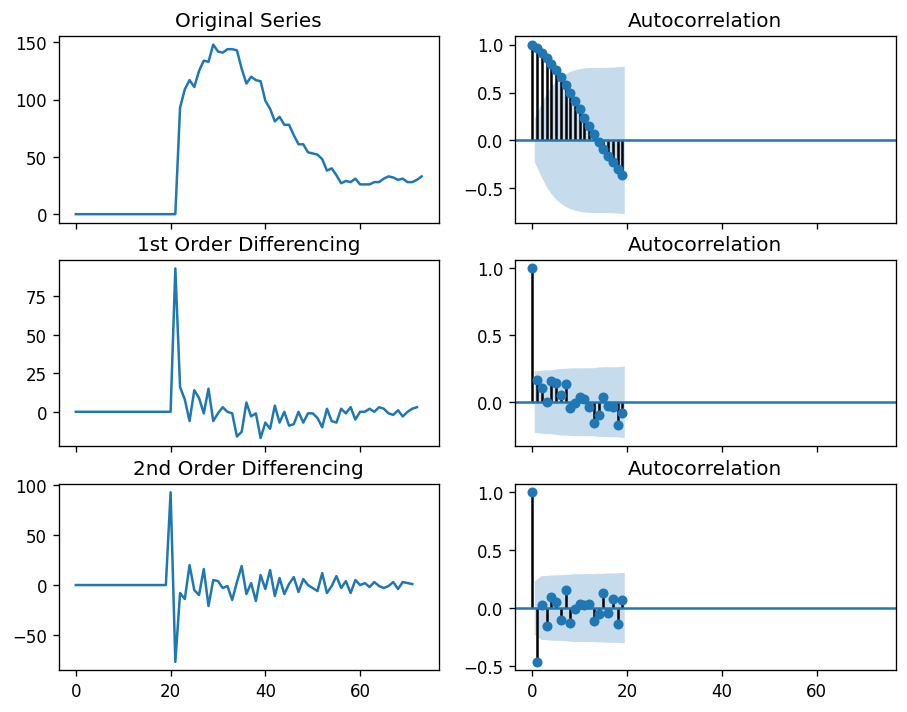

In [6]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
fig, axes = plt.subplots(3, 2, sharex=True)

# Original Series
axes[0, 0].plot(df.values); axes[0, 0].set_title('Original Series')
plot_acf(df.values, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(np.diff(df)); axes[1, 0].set_title('1st Order Differencing')
plot_acf(np.diff(df), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(np.diff(np.diff(df))); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(np.diff(np.diff(df)), ax=axes[2, 1])

plt.show()

Encontrar el valor de **p**.<br/>
Vamos a identificar si el modelo necesita términos AR. Para ello inspeccionaremos el PARTIAL Autocorrelation (PACF) plot, que lo que hace es la correlación entre las series y su retardo, excluyendo las contribuciones de los retrasos intermedios.



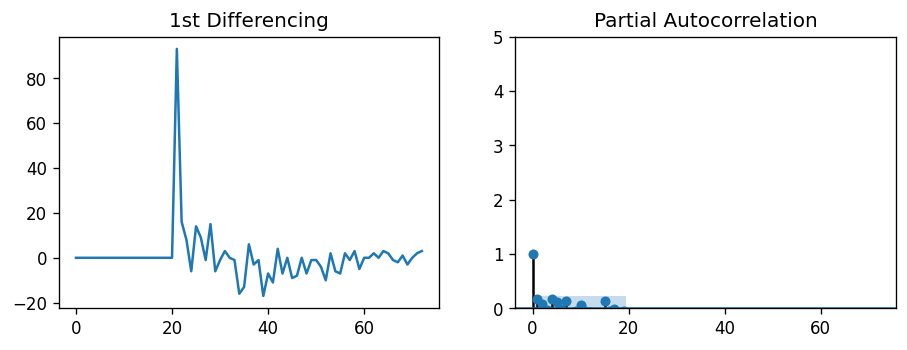

In [7]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(np.diff(df)); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(np.diff(df), ax=axes[1])

plt.show()

Encontrar el valor de **q**.<br/>
Nos centraremos en el ACF plot para saber el número de términos MA, siéndo éste el error del retraso en la predicción.


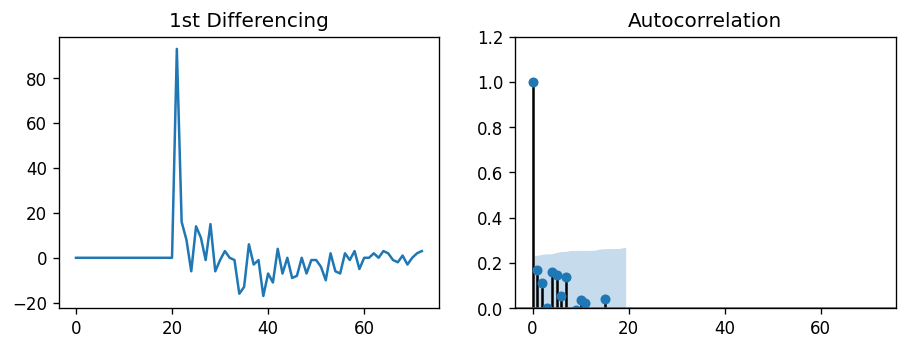

In [8]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
fig, axes = plt.subplots(1, 2, sharex=True)

axes[0].plot(np.diff(df)); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(np.diff(df), ax=axes[1])

plt.show()

Construcción del modelo ARIMA:<br/>
El propio modelo nos muestra los coeficientes y los pesos que les ha dado a dichos coeficientes.
Para que un modelo sea bueno, el término MA2 debe ser cercano a 0 y el P>|z| debería ser idealmente menor que 0.05.<br/>
debemos buscar tambien reducir el AIC.

In [9]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(df.values, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   73
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -285.129
Method:                       css-mle   S.D. of innovations             12.018
Date:                Wed, 27 May 2020   AIC                            578.258
Time:                        15:20:40   BIC                            587.420
Sample:                             1   HQIC                           581.909
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.4578      2.221      0.206      0.837      -3.895       4.810
ar.L1.D.y      0.8033      0.203      3.958      0.000       0.406       1.201
ma.L1.D.y     -0.6814      0.247     -2.755      0.0

Vamos a observar los residuos para ver que no hay patrones, buscando *medias* y *varianzas* constantes.<br/>
Si en el error residual, la media es cercana a 0, y una varianza uniforme, iremos por buen camino.

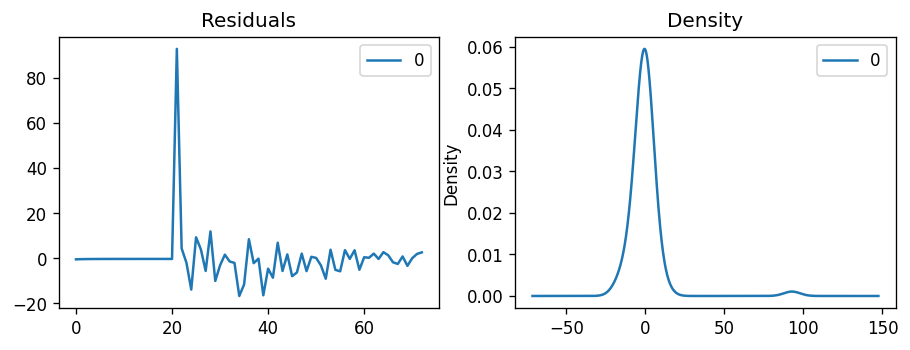

In [10]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Comprobación de lo predicho respecto a lo real.<br/>
Al añadir dynamic=False, los valores de retardo de la muestra son empleados para la predicción

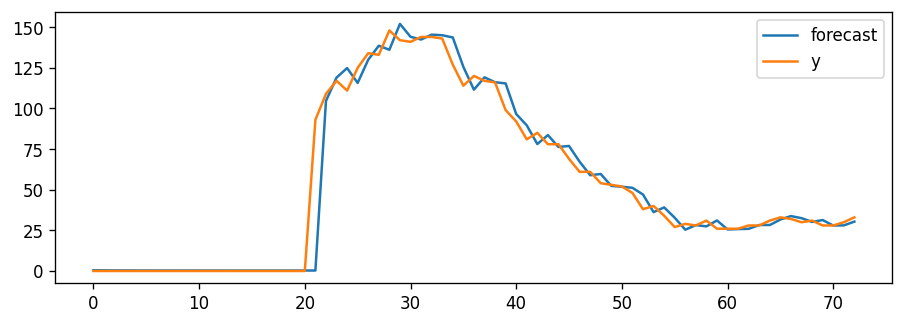

In [11]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=False)
plt.show()

Comprobación del modelo manualmente empleando conjunto de test y conjunto de entrenamiento.<br/>
Partimos el dataset en entrenamiento y test.

In [12]:
# Comprobamos la longitud de nuestro dataset
print(df.count) #74

from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2,shuffle=False)

<bound method Series.count of Date
2020-03-01     0.0
2020-03-02     0.0
2020-03-03     0.0
2020-03-04     0.0
2020-03-05     0.0
              ... 
2020-05-09    31.0
2020-05-10    28.0
2020-05-11    28.0
2020-05-12    30.0
2020-05-13    33.0
Name: H. Tomelloso, Length: 74, dtype: float64>


                             ARIMA Model Results                              
Dep. Variable:         D.H. Tomelloso   No. Observations:                   58
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -232.986
Method:                       css-mle   S.D. of innovations             13.429
Date:                Wed, 27 May 2020   AIC                            473.973
Time:                        15:20:40   BIC                            482.215
Sample:                    03-02-2020   HQIC                           477.183
                         - 04-28-2020                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.3837      2.779      0.138      0.890      -5.062       5.830
ar.L1.D.H. Tomelloso     0.8036      0.228      3.520      0.000       0.356       1.251
ma.L1.D.H. T

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


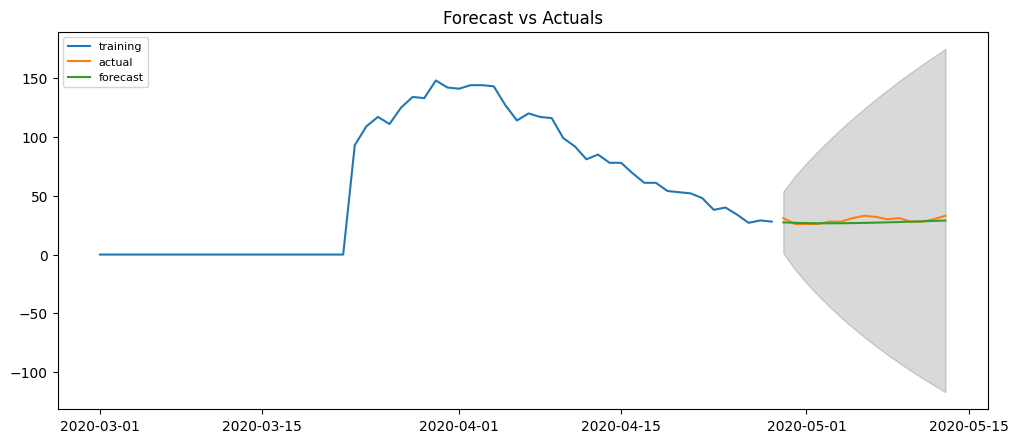

In [13]:
# Build Model
#model = ARIMA(train, order=(3,2,1))  
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

# Forecast
fc, se, conf = fitted.forecast(15, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Métricas para las predicciones de series temporales:
1.   Mean Absolute Percentage Error (MAPE)
2.   Mean Error (ME)
3.   Mean Absolute Error (MAE)
4.   Mean Percentage Error (MPE)
5.   Root Mean Squared Error (RMSE)
6.   Lag 1 Autocorrelation of Error (ACF1)
7.   Correlation between the Actual and the Forecast (corr)
8.   Min-Max Error (minmax)

Básicamente se emplean MAPE, Correlation y Min-Max, esto es debido a que estas 3 nos dan valores entre 0 y 1, mientras que las otras son medidas cuantitativas con su escala propia.

In [14]:
from statsmodels.tsa.stattools import acf
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

forecast_accuracy(fc, test.values)

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


{'acf1': 0.5046623561492344,
 'corr': 0.37616472151982305,
 'mae': 2.375882354166213,
 'mape': 0.07696175236127906,
 'me': -2.0279587045252,
 'minmax': 0.07677386005602183,
 'mpe': -0.06367768011520318,
 'rmse': 2.986888092663986}

El mape, el valor que nos salga, nos indica la imprecisión del modelo, por lo que si hacemos 1-MAPE, obtendremos la precisión de nuestro modelo en el número de predicciones indicadas.

# Auto ARIMA

In [15]:
#!pip install pmdarima
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(df, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
Fit ARIMA(1,2,1)x(0,0,0,0) [intercept=True]; AIC=575.461, BIC=584.568, Time=0.159 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=True]; AIC=607.082, BIC=611.635, Time=0.013 seconds
Fit ARIMA(1,2,0)x(0,0,0,0) [intercept=True]; AIC=591.837, BIC=598.667, Time=0.041 seconds
Fit ARIMA(0,2,1)x(0,0,0,0) [intercept=True]; AIC=574.500, BIC=581.330, Time=0.043 seconds
Fit ARIMA(0,2,0)x(0,0,0,0) [intercept=False]; AIC=605.082, BIC=607.359, Time=0.009 seconds
Fit ARIMA(0,2,2)x(0,0,0,0) [intercept=True]; AIC=576.158, BIC=585.265, Time=0.059 seconds
Fit ARIMA(1,2,2)x(0,0,0,0) [intercept=True]; AIC=578.495, BIC=589.878, Time=0.076 seconds
Total fit time: 0.411 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   74
Model:               SARIMAX(0, 2, 1)   Log Likelihood                -284.250
Date:                Wed, 27 May 2020   AIC                

Interpretación de los plots residuales en ARIMA

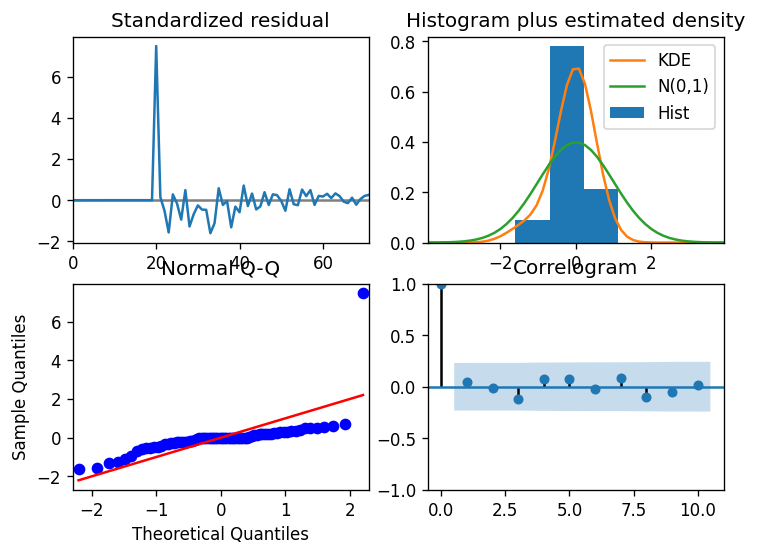

In [16]:
#!pip install statsmodels --upgrade
model.plot_diagnostics(figsize=(7,5))
plt.show()

*   Arriba izda: errores residuales fluctuan respecto a media 0 y tienen una varianza uniforme.
*   Arriba drcha: distribución normal media cero
*   Abajo izda: si los puntos están alineados con la linea roja
*   Abajo drcha: si en el correlograma apareciese algún tipo de patrón



# Predicción de valores

DatetimeIndex(['2020-05-13', '2020-05-14', '2020-05-15', '2020-05-16',
               '2020-05-17', '2020-05-18', '2020-05-19', '2020-05-20',
               '2020-05-21', '2020-05-22', '2020-05-23', '2020-05-24',
               '2020-05-25', '2020-05-26', '2020-05-27', '2020-05-28',
               '2020-05-29', '2020-05-30', '2020-05-31', '2020-06-01',
               '2020-06-02', '2020-06-03', '2020-06-04', '2020-06-05'],
              dtype='datetime64[ns]', freq='D')


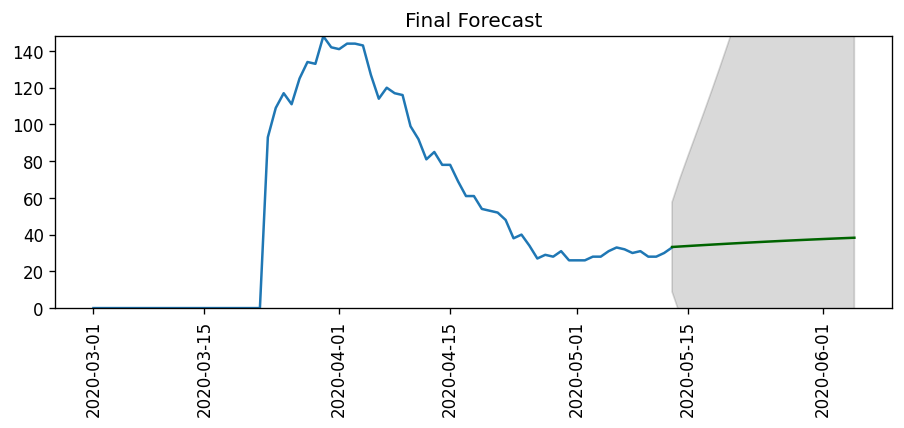

In [17]:
import datetime
# Forecast
n_periods = 24
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)

#index_of_fc= pd.date_range(start=(df.index[-1]+datetime.timedelta(days=1)), periods=n_periods, freq='D')
index_of_fc= pd.date_range(start=(df.index[-1]), periods=n_periods, freq='D')

print(index_of_fc)
# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast")
plt.ylim(df.min(), df.max())
plt.xticks(rotation=90)
!mkdir img/
plt.savefig('img/hospitalizados_cm.jpg', bbox_inches='tight')
plt.show()



In [18]:
fc_series

2020-05-13    33.270582
2020-05-14    33.536843
2020-05-15    33.798784
2020-05-16    34.056405
2020-05-17    34.309705
2020-05-18    34.558685
2020-05-19    34.803345
2020-05-20    35.043685
2020-05-21    35.279705
2020-05-22    35.511404
2020-05-23    35.738783
2020-05-24    35.961841
2020-05-25    36.180580
2020-05-26    36.394998
2020-05-27    36.605096
2020-05-28    36.810874
2020-05-29    37.012331
2020-05-30    37.209468
2020-05-31    37.402285
2020-06-01    37.590782
2020-06-02    37.774958
2020-06-03    37.954814
2020-06-04    38.130350
2020-06-05    38.301566
Freq: D, dtype: float64

Exportamos los resultados a un excel

In [0]:
!mkdir rslt/
df.to_csv('rslt/fc_series.csv', encoding='ISO-8859-1')